In [1]:
%cd ~/projects/kaggle/quora
from matplotlib import pyplot as plt
%matplotlib inline

/Users/trung/projects/kaggle/quora


In [2]:
import pandas as pd
import nltk
import numpy as np
from __future__ import print_function, division
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [50]:
d = pd.read_csv('data/raw/train.csv')
dt = pd.read_csv('data/raw/test.csv')

In [51]:
d['question1'].fillna('', inplace=True)
d['question1'] = d['question1'].map(lambda x: x.replace(' ?', '?'))
d['question2'].fillna('', inplace=True)
d['question2'] = d['question2'].map(lambda x: x.replace(' ?', '?'))
dt['question1'].fillna('', inplace=True)
dt['question1'] = dt['question1'].map(lambda x: x.replace(' ?', '?'))
dt['question2'].fillna('', inplace=True)
dt['question2'] = dt['question2'].map(lambda x: x.replace(' ?', '?'))

## Data with all stop words removed

In [53]:
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
stop_words = set(["http","www","img","border","home","body","a","about","above","after","again","against","all","am","an",
"and","any","are","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can't",
"cannot","could","couldn't","did","didn't","do","does","doesn't","doing","don't","down","during","each","few","for","from",
"further","had","hadn't","has","hasn't","have","haven't","having","he","he'd","he'll","he's","her","here","here's","hers",
"herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","isn't","it","it's","its",
"itself","let's","me","more","most","mustn't","my","myself","no","nor","not","of","off","on","once","only","or","other","ought",
"our","ours","ourselves","out","over","own","same","shan't","she","she'd","she'll","she's","should","shouldn't","so","some","such",
"than","that","that's","the","their","theirs","them","themselves","then","there","there's","these","they","they'd","they'll","they're",
"they've","this","those","through","to","too","under","until","up","very","was","wasn't","we","we'd","we'll","we're","we've","were",
"weren't","what","what's","when","when's""where","where's","which","while","who","who's","whom","why","why's","with","won't","would",
"wouldn't","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves", ''])

def remove_stopwords(s):
    tokens = s.split()
    nonstops = [x for x in tokens if x.lower() not in stop_words]
    return ' '.join(nonstops)


In [54]:
new_d = d.copy()
new_d['question1'] = d['question1'].apply(remove_stopwords)
new_d['question2'] = d['question2'].apply(remove_stopwords)

In [55]:
d.head(), new_d.head()

(   id  qid1  qid2                                          question1  \
 0   0     1     2  What is the step by step guide to invest in sh...   
 1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
 2   2     5     6  How can I increase the speed of my internet co...   
 3   3     7     8  Why am I mentally very lonely? How can I solve...   
 4   4     9    10  Which one dissolve in water quikly sugar, salt...   
 
                                            question2  is_duplicate  
 0  What is the step by step guide to invest in sh...             0  
 1  What would happen if the Indian government sto...             0  
 2  How can Internet speed be increased by hacking...             0  
 3  Find the remainder when [math]23^{24}[/math] i...             0  
 4            Which fish would survive in salt water?             0  ,
    id  qid1  qid2                                          question1  \
 0   0     1     2         step step guide invest share market ind

In [56]:
new_dt = dt
new_dt['question1'] = dt['question1'].apply(remove_stopwords)
new_dt['question2'] = dt['question2'].apply(remove_stopwords)

In [58]:
new_d.shape, new_dt.shape

((404290, 6), (2345796, 3))

In [57]:
new_d.to_csv('data/processed/train_no_stopwords.csv', index=False)
new_dt.to_csv('data/processed/test_no_stopwords.csv', index=False)

## Data with stemmers

Already in data/processed/ as output from script with Stacknet.

## Build model on each data variant

In [203]:
# Set the variant
variant = 'data/variant1/'
inp_train = variant + 'train_orig.csv'
inp_test = variant + 'test_orig.csv'
out = variant + 'submission.csv'

In [ ]:
d = pd.read_csv(inp_train)
dt = pd.read_csv(inp_test)

In [ ]:
train1 = pd.read_csv(variant+'train_set1.csv')
train2 = pd.read_csv(variant+'train_set2.csv')
train3 = pd.read_csv(variant+'train_set3.csv')
test1 = pd.read_csv(variant+'test_set1.csv')
test2 = pd.read_csv(variant+'test_set2.csv')
test3 = pd.read_csv(variant+'test_set3.csv')
train4 = pd.read_csv(variant+'train_set4.csv')
test4 = pd.read_csv(variant+'test_set4.csv')

In [210]:
train3.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1, inplace=True)
test3.drop(['test_id', 'question1', 'question2'], axis=1, inplace=True)
test1.drop('test_id', axis=1, inplace=True)

In [211]:
test1.columns, test2.columns, test3.columns, test4.columns

(Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
        u'diff_chars', u'len_word_q1', u'len_word_q2', u'diff_words',
        u'common_words', u'fuzz_qratio', u'fuzz_WRatio', u'fuzz_partial_ratio',
        u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
        u'fuzz_token_set_ratio', u'fuzz_token_sort_ratio', u'wmd',
        u'cosine_distance', u'cityblock_distance', u'jaccard_distance',
        u'canberra_distance', u'euclidean_distance', u'braycurtis_distance',
        u'skew_q1vec', u'skew_q2vec', u'ratio_skew', u'kur_q1vec', u'kur_q2vec',
        u'ratio_kur', u'cosine_distance2', u'cityblock_distance2',
        u'jaccard_distance2', u'canberra_distance2', u'euclidean_distance2',
        u'braycurtis_distance2', u'skew_q1vec2', u'skew_q2vec2', u'ratio_skew2',
        u'kur_q1vec2', u'kur_q2vec2', u'ratio_kur2'],
       dtype='object'),
 Index([u'x0', u'x1', u'x2', u'x3', u'x4', u'x5', u'x6', u'x7', u'x8', u'x9',
        u'x10', u'x11'

In [69]:
train5 = pd.read_csv('data/processed/train_set5.csv')
test5 = pd.read_csv('data/processed/test_set5.csv')

In [182]:
train5.corrwith(d.is_duplicate)

q1_hash      -0.206498
q2_hash      -0.349626
q1_freq       0.296621
q2_freq       0.198609
ratio_freq   -0.098409
dtype: float64

In [76]:
train5.head(), test5.head()

(   q1_hash  q2_hash  q1_freq  q2_freq  ratio_freq
 0        0   290457        1        2    0.500000
 1        1    16739        8        3    2.666667
 2        2   290458        2        1    2.000000
 3        3   290459        1        1    1.000000
 4        4   290460        3        1    3.000000,
    q1_hash  q2_hash  q1_freq  q2_freq  ratio_freq
 0   537362  2680915        1        1           1
 1   537363  1258712        2        2           1
 2   537364  2680916        1        1           1
 3   537365  2680917        1        1           1
 4   537366  2680918        1        1           1)

In [74]:
train5.drop(['id', 'is_duplicate'], axis=1, inplace=True)
test5.drop(['id'], axis=1, inplace=True)

In [75]:
train5['ratio_freq'] = train5['q1_freq'] / train5['q2_freq']
test5['ratio_freq'] = test5['q1_freq'] / test5['q2_freq']

In [212]:
train = pd.concat([train1, train2, train3, train4, train5], axis=1)
test = pd.concat([test1, test2, test3, test4, test5], axis=1)
dup_columns = ['z_len1', 'z_len2', 'z_word_len1', 'z_word_len2', 'x3', 'x12', 'x21']
train.drop(dup_columns, axis=1, inplace=True)
test.drop(dup_columns, axis=1, inplace=True)

In [213]:
train.columns

Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'diff_chars', u'len_word_q1', u'len_word_q2', u'diff_words',
       u'common_words', u'fuzz_qratio', u'fuzz_WRatio', u'fuzz_partial_ratio',
       u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
       u'fuzz_token_set_ratio', u'fuzz_token_sort_ratio', u'wmd',
       u'cosine_distance', u'cityblock_distance', u'jaccard_distance',
       u'canberra_distance', u'euclidean_distance', u'braycurtis_distance',
       u'skew_q1vec', u'skew_q2vec', u'ratio_skew', u'kur_q1vec', u'kur_q2vec',
       u'ratio_kur', u'cosine_distance2', u'cityblock_distance2',
       u'jaccard_distance2', u'canberra_distance2', u'euclidean_distance2',
       u'braycurtis_distance2', u'skew_q1vec2', u'skew_q2vec2', u'ratio_skew2',
       u'kur_q1vec2', u'kur_q2vec2', u'ratio_kur2', u'x0', u'x1', u'x2', u'x4',
       u'x5', u'x6', u'x7', u'x8', u'x9', u'x10', u'x11', u'x13', u'x14',
       u'x15', u'x16', u'x17', u'x1

In [214]:
len(train.columns)

88

In [229]:
train.to_csv('data/processed/train.csv', index=False)
test.to_csv('data/processed/test.csv', index=False)

In [232]:
## for stacknet model
stacknet_train = pd.concat([d.is_duplicate, train], axis=1)

In [255]:
#stacknet_train.to_csv('data/processed/stacknet_train.csv', index=False, header=False)
test.to_csv('data/processed/stacknet_test.csv', index=False, header=False)

In [4]:
train = pd.read_csv('data/processed/train.csv')
test = pd.read_csv('data/processed/test.csv')

# No over-sampling

We don't use over-sampling but instead use score calibration.

## Cross-validation to select hyper-parameters

In [6]:
y = d.is_duplicate
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=1110)

In [7]:
# 0.400918 val, 0.287256 train (before magic features), 0.2824 LB
# 0.30697 val, 0.229344 train, 0.25897 LB
# 0.305575 val, 0.227383 train, 0.25411 LB
# 0.304617 val, 0.214529 train, 
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=32, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=4000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val), (X_train, y_train)],
          eval_metric='logloss',
          early_stopping_rounds=50
         )

[1]	valid_0's binary_logloss: 0.669368	valid_1's binary_logloss: 0.66943
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's binary_logloss: 0.649006	valid_1's binary_logloss: 0.649051
[3]	valid_0's binary_logloss: 0.631004	valid_1's binary_logloss: 0.630933
[4]	valid_0's binary_logloss: 0.615592	valid_1's binary_logloss: 0.615453
[5]	valid_0's binary_logloss: 0.598535	valid_1's binary_logloss: 0.598375
[6]	valid_0's binary_logloss: 0.582569	valid_1's binary_logloss: 0.58244
[7]	valid_0's binary_logloss: 0.568545	valid_1's binary_logloss: 0.568443
[8]	valid_0's binary_logloss: 0.557509	valid_1's binary_logloss: 0.557353
[9]	valid_0's binary_logloss: 0.545	valid_1's binary_logloss: 0.54484
[10]	valid_0's binary_logloss: 0.533268	valid_1's binary_logloss: 0.533038
[11]	valid_0's binary_logloss: 0.522093	valid_1's binary_logloss: 0.521901
[12]	valid_0's binary_logloss: 0.512094	valid_1's binary_logloss: 0.511848
[13]	valid_0's binary_logloss: 0.502606	valid_1's binary_logl

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=4000, nthread=-1, num_leaves=32,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from matplotlib import pyplot as plt
def evaluate(label, pred_prob, pred_label):
    plt.hist(pred_prob[label == 1])
    plt.title('positive class')
    plt.figure()
    plt.hist(pred_prob[label == 0])
    plt.title('negative class')

    print(confusion_matrix(label, pred_label))
    print(classification_report(label, pred_label, target_names=['not duplicate', 'duplicate']))
    print(roc_auc_score(label, pred_prob))


[[45654  5294]
 [ 6191 23719]]
               precision    recall  f1-score   support

not duplicate       0.88      0.90      0.89     50948
    duplicate       0.82      0.79      0.81     29910

  avg / total       0.86      0.86      0.86     80858

0.937010170156


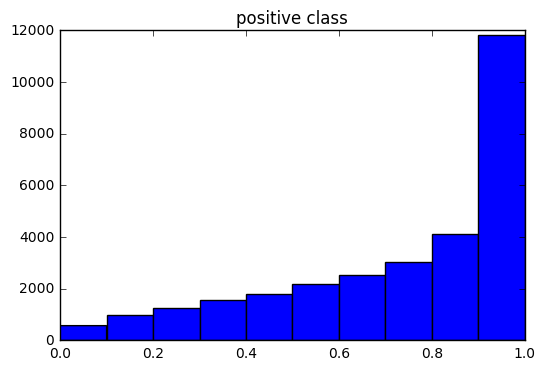

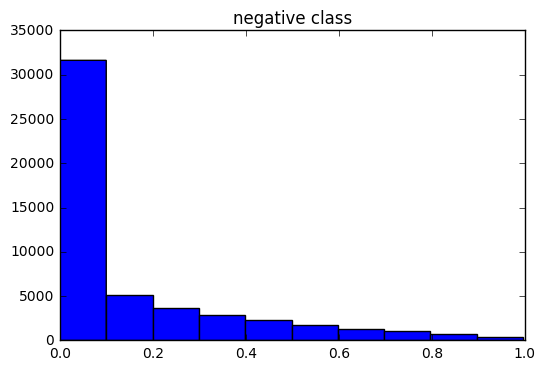

In [13]:
p = model.predict_proba(X_val)[:,1]
l = model.predict(X_val)
evaluate(y_val, p, l)

In [14]:
def print_some(d, indice):
    for i in indice:
        print(d.is_duplicate[i])
        print(d.question1[i])
        print(d.question2[i])


In [17]:
wrong1 = X_val[np.logical_and(y_val == 1, p < 0.2)].index
print_some(d, wrong1[0:10])

1
Which kind of guitar should I buy as an amateur?
What kind of guitar should a beginner buy?
1
Is there a reason why most Quora posters are anti conservative liberals?
Why is Quora full of liberals?
1
What is the must-have cuisine in Munnar?
What should I eat in Munnar?
1
What product should I use for my hair?
What products should be applied on hair?
1
Do you know what is hair transplant?
What is a hair transplant?
1
Did Hindus eat beef during vedic ages?
Was beef eating common during the Vedic times in India? If yes, how did it become sacrilegious over time?
1
How is skin color determined in babies?
What will the skin color of the baby be, if the mother is black and the father is white?
1
I am going to put my immigration case for Canada. Is there any way to get job before landing in Canada?
How can I get job offer from Canada?
1
What is the best iPhone app and why?
Which is the best app to keep on your iPhone?
1
Who are some notable people on Quora worth following?
Who are some of th

## Full training

In [238]:
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=32, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=model.best_iteration, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(train, y,
          eval_set=[(train, y)],
          eval_metric='logloss')

[1]	valid_0's binary_logloss: 0.669457
[2]	valid_0's binary_logloss: 0.649039
[3]	valid_0's binary_logloss: 0.630997
[4]	valid_0's binary_logloss: 0.615498
[5]	valid_0's binary_logloss: 0.598327
[6]	valid_0's binary_logloss: 0.582322
[7]	valid_0's binary_logloss: 0.568315
[8]	valid_0's binary_logloss: 0.557368
[9]	valid_0's binary_logloss: 0.544985
[10]	valid_0's binary_logloss: 0.533267
[11]	valid_0's binary_logloss: 0.522105
[12]	valid_0's binary_logloss: 0.511769
[13]	valid_0's binary_logloss: 0.502464
[14]	valid_0's binary_logloss: 0.493527
[15]	valid_0's binary_logloss: 0.485509
[16]	valid_0's binary_logloss: 0.478392
[17]	valid_0's binary_logloss: 0.470873
[18]	valid_0's binary_logloss: 0.46476
[19]	valid_0's binary_logloss: 0.458116
[20]	valid_0's binary_logloss: 0.451875
[21]	valid_0's binary_logloss: 0.446357
[22]	valid_0's binary_logloss: 0.440735
[23]	valid_0's binary_logloss: 0.43548
[24]	valid_0's binary_logloss: 0.430947
[25]	valid_0's binary_logloss: 0.42642
[26]	valid_0

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=2666, nthread=-1, num_leaves=32,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [218]:
imp = pd.DataFrame({'feature': test.columns, 'importance': model.feature_importances_})

In [219]:
imp.sort_values(by='importance', ascending=False)

,feature,importance
84,q2_hash,0.025850
83,q1_hash,0.023630
17,wmd,0.023354
63,x24,0.022848
47,x6,0.022169
87,ratio_freq,0.021789
27,kur_q1vec,0.021110
55,x15,0.020432
24,skew_q1vec,0.020259
28,kur_q2vec,0.019914


In [220]:
def write_predictions(model, x_test, location):
    y_pred = model.predict_proba(x_test, num_iteration=model.best_iteration)[:,1]
    print(np.mean(y_pred))
    sub = pd.DataFrame({'test_id': dt.test_id, 'is_duplicate': y_pred})
    sub.to_csv(location, index=False)
    return y_pred

In [239]:
write_predictions(model, test, 'results/model2.csv')

0.121488248952


array([ 0.007756  ,  0.3491851 ,  0.41174191, ...,  0.00169542,
        0.57326666,  0.19064052])

## Ensemble

Results so far:
- (Over-sampled) Stacknet + model with features set 1, 2, 3 => LB score of 0.30082
- (Over-sampled) Stacknet + model with features set 1, 2, 3, 4 => LB score of 0.300xx
- Best single model: 0.29572 (non-calibrated), 0.30xx (calibrated). Mean pred before cal is 0.12 and mean pred after is 0.06 so probably when mean prediction is small there's no need for calibration
- Bboth calibrated: Best single model + stacknet: 0.26378
- Best single model (uncalibrated) + stacknet (calibrated): 0.25411

Note that correlation between stacknet and model is only 0.5, so they are two complementary model. Can also use this stacknet model score to build another stacknet model...

TODOs:
1) add features on data where all question words are removed
2) augment data
3) Run ANOTHER stacknet model with current features (non-sparse)

In [222]:
# https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/
prop_train = 0.37 # proportion of positives in training
prop_test = 0.165 # prop. of positives in training
alpha = prop_test / prop_train
beta = (1 - prop_test) / (1 - prop_train)
def calibrate(prob):
    return alpha * prob / (alpha * prob + beta * (1 - prob))

In [248]:
def read_stacknet_pred(path):
    y = pd.read_csv(path, header=None)
    y.columns = ['dummy', 'is_duplicate']
    y.drop('dummy', inplace=True, axis=1)
    return y

In [240]:
y1 = pd.read_csv('results/trung_final.csv')
y2 = read_stacknet_pred('results/stacknet.csv')
y2['test_id'] = y1.test_id
y3 = pd.read_csv('results/xgb_seed12357_n315.csv')
y4 = pd.read_csv('results/model2.csv')

In [256]:
y5 = read_stacknet_pred('results/stacknet2.csv')

In [259]:
np.mean(y2.is_duplicate), np.mean(y5.is_duplicate), np.mean(y4.is_duplicate)

(0.2039776797034145, 0.13522167813263997, 0.1214882489516759)

In [262]:
np.corrcoef(y4.is_duplicate, y5.is_duplicate)

array([[ 1.        ,  0.90540037],
       [ 0.90540037,  1.        ]])

In [265]:
y2cal = calibrate(y2.is_duplicate)
y4cal = calibrate(y4.is_duplicate)
y5cal = calibrate(y5.is_duplicate)
y5cal.mean(), y2cal.mean(), y4cal.mean(), np.corrcoef(y4cal, y5cal)

(0.06413366922000376,
 0.11797916397188052,
 0.06042476624071721,
 array([[ 1.        ,  0.85852261],
        [ 0.85852261,  1.        ]]))

In [266]:
sub = pd.DataFrame({'is_duplicate': calibrate(y2.is_duplicate) + y4.is_duplicate + y5.is_duplicate,
                   'test_id': y1.test_id})
sub.is_duplicate = sub.is_duplicate / 3

In [267]:
sub.to_csv('results/ensemble.csv', index=False)

In [8]:
sub = pd.read_csv('results/ensemble.csv.gz')
sub2 = pd.read_csv('results/test.csv.gz')

(array([  1.43867600e+06,   2.84282000e+05,   2.28271000e+05,
          1.86643000e+05,   1.13645000e+05,   5.32860000e+04,
          2.47210000e+04,   1.10590000e+04,   3.90700000e+03,
          1.30600000e+03]),
 array([  1.43300679e-05,   9.97896058e-02,   1.99564882e-01,
          2.99340157e-01,   3.99115433e-01,   4.98890709e-01,
          5.98665985e-01,   6.98441260e-01,   7.98216536e-01,
          8.97991812e-01,   9.97767088e-01]),
 <a list of 10 Patch objects>)

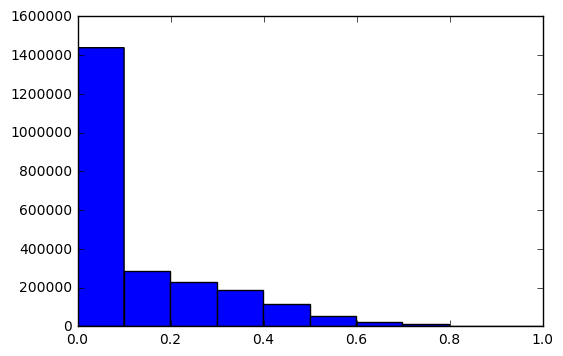

In [268]:
plt.hist(sub.is_duplicate.values)

(array([ 1481984.,   279845.,   219625.,   161760.,   102882.,    51692.,
           23931.,    12850.,     7621.,     3606.]),
 array([  5.83355767e-06,   9.98222683e-02,   1.99638703e-01,
          2.99455138e-01,   3.99271572e-01,   4.99088007e-01,
          5.98904442e-01,   6.98720876e-01,   7.98537311e-01,
          8.98353746e-01,   9.98170181e-01]),
 <a list of 10 Patch objects>)

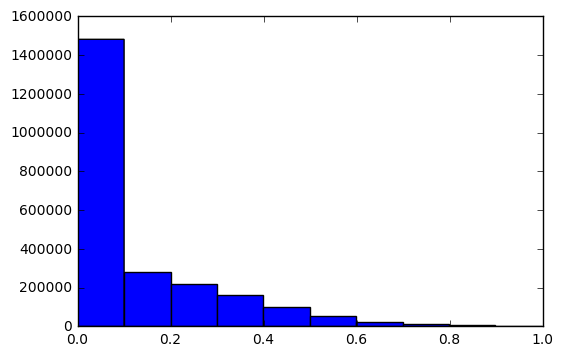

In [228]:
plt.hist(sub.is_duplicate.values)